# DETR decoder attention visualization

```bash
!git clone https://github.com/facebookresearch/detr
```

> Download the pretrained model ([detr-r50-e632da11.pth](https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth)) and put it in `./detr/params/` folder.

In [1]:
import sys
sys.path.append('./detr/')
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
torch.set_grad_enabled(False)
from models import build_model
import argparse

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser

parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args = parser.parse_args(args=["--coco_path", "", "--resume", "./detr/params/detr-r50-e632da11.pth"])
device = torch.device(args.device)

# initialize model

In [3]:
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

# Data Transform

In [4]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Read img

In [5]:
from PIL import Image
pil_img = Image.open('cats.jpg').convert('RGB')
w, h = pil_img.size
target_size = torch.tensor([[h, w]], dtype=torch.float32).to(device)
img = transform(pil_img).unsqueeze(0).to(device)

In [6]:
print(img.shape)
print(target_size)

torch.Size([1, 3, 800, 1422])
tensor([[ 675., 1200.]], device='cuda:0')


# Forward

In [7]:
outputs = model(img)

# Postprocess

In [8]:
results = postprocessors['bbox'](outputs, target_size)

In [9]:
results[0].keys()

dict_keys(['scores', 'labels', 'boxes'])

In [10]:
N = 2
topN_scores, topN_index = torch.topk(results[0]['scores'], N)

In [11]:
topN_boxes = results[0]['boxes'][topN_index]
topN_labels = [CLASSES[l] for l in results[0]['labels'][topN_index]]

# visualize results

In [12]:
import matplotlib.pyplot as plt
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for s, l, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

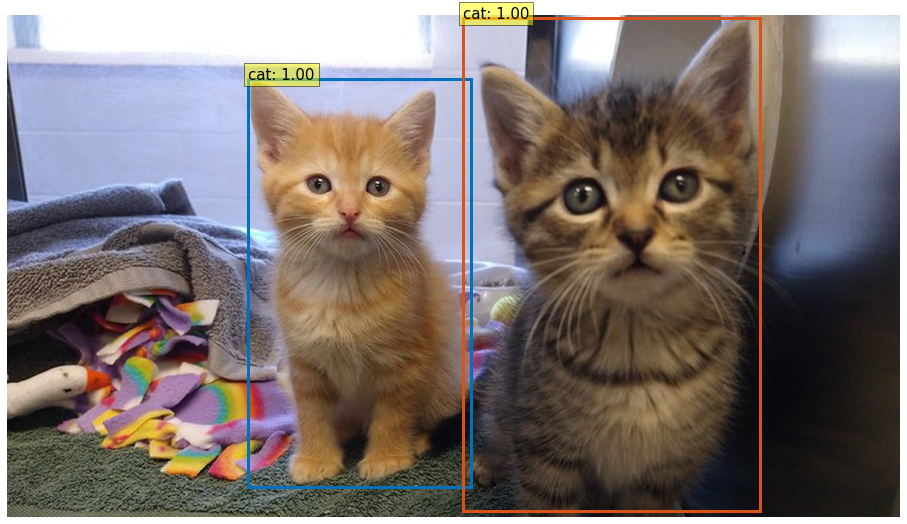

In [13]:
plot_results(pil_img, topN_scores, topN_labels, topN_boxes)

# inference code

In [14]:
def inference_once(img_name, N=11):
    pil_img = Image.open(img_name).convert('RGB')
    w, h = pil_img.size
    target_size = torch.tensor([[h, w]], dtype=torch.float32).to(device)
    img = transform(pil_img).unsqueeze(0).to(device)
    outputs = model(img)
    results = postprocessors['bbox'](outputs, target_size)

    topN_scores, topN_index = torch.topk(results[0]['scores'], N)
    topN_boxes = results[0]['boxes'][topN_index]
    topN_labels = [CLASSES[l] for l in results[0]['labels'][topN_index]]
    return {
        "pil_img": pil_img,
        "topN_scores": topN_scores,
        "topN_boxes": topN_boxes,
        "topN_labels": topN_labels
    }

# Set hook and inference once

In [15]:
from json_dump_util import json_dumps_print
input_output_shape = {}
input_output = {}

def hook_function(name):
    def tuple_shape_hook(x):
        shape = []
        if isinstance(x, tuple):
            for xi in x:
                shape += tuple_shape_hook(xi)
            return [shape]
        elif isinstance(x, torch.Tensor):
            return [x.shape]
        else:
            return ["not a tensor"]
    
    def tuple_hook(x):
        value = []
        if isinstance(x, tuple):
            for xi in x:
                value += tuple_hook(xi)
            return [value]
        else:
            return [x]
    
    def hook(model, inputs, outputs):
        input_output_shape.update({
            f'{name} input': tuple_shape_hook(inputs),
            f'{name} output': tuple_shape_hook(outputs)
        })
        input_output.update({
            f'{name} input': tuple_hook(inputs),
            f'{name} output': tuple_hook(outputs)
        })


    return hook


hooks = [
    model.backbone[-2].register_forward_hook(hook_function('backbone_feature')),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(hook_function('encoder last layer')),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(hook_function('decoder last layer'))
]

inference_once("cats.jpg")

json_dumps_print(input_output_shape)

for hook in hooks:
    hook.remove()

{
    "backbone_feature input": [
        ["not a tensor"]
    ],
    "backbone_feature output": ["not a tensor"],
    "encoder last layer input": [
        [
            [1125, 1, 256],
            [1125, 1, 256]
        ]
    ],
    "encoder last layer output": [
        [
            [1125, 1, 256],
            [1, 1125, 1125]
        ]
    ],
    "decoder last layer input": [
        [
            [100, 1, 256],
            [1125, 1, 256]
        ]
    ],
    "decoder last layer output": [
        [
            [100, 1, 256],
            [1, 100, 1125]
        ]
    ]
}


# Notice

if your pytorch is under 2.0.0 version, and you want to see the input of the decoder layer, you need to modify the following code

```python
class TransformerDecoderLayer(nn.Module):
    ...
    def forward_post(self, ...):
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
    ....
```

in `detr/models/transformer.py` to

```python
class TransformerDecoderLayer(nn.Module):
    ...
    def forward_post(self, ...):
        tgt2 = self.multihead_attn(self.with_pos_embed(tgt, query_pos),
                                   self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
    ....
```

As for the reason, please refer to [this issue](https://github.com/pytorch/pytorch/issues/35643)

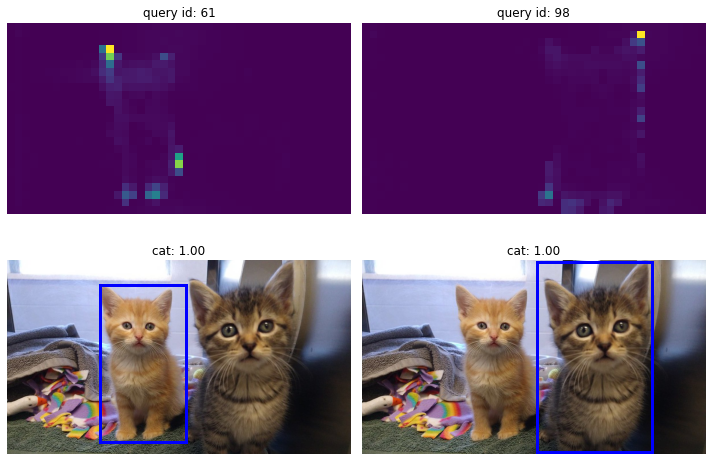

In [16]:
# get the feature map shape
conv_features = input_output["backbone_feature output"][0]
h, w = conv_features['0'].tensors.shape[-2:]

dec_attn_weights = input_output["decoder last layer output"][0]

fig, axs = plt.subplots(ncols=N, nrows=2, figsize=(5*N, 7))
colors = COLORS * 100
for idx, (topN_idx, ax_i, (xmin, ymin, xmax, ymax)) in enumerate(zip(topN_index, axs.T, topN_boxes.cpu())):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[1][0, topN_idx].view(h, w).cpu(), cmap='inferno')
    ax.axis('off')
    ax.set_title(f'query id: {topN_idx.item()}')
    ax = ax_i[1]
    ax.imshow(pil_img)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color='blue', linewidth=3))
    ax.axis('off')
    l = topN_labels[idx]
    s = topN_scores[idx]
    ax.set_title(f'{l}: {s:0.2f}')
fig.tight_layout()